In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn import preprocessing

/home/sean/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
games = pd.read_csv('nfl_games.csv')
games = games.dropna()
games.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1
0,1920-09-26,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0
1,1920-10-03,1920,0,0,AKR,WHE,1503.420,1300.000,0.824212,43,0,1.0
2,1920-10-03,1920,0,0,RCH,ABU,1503.420,1300.000,0.824212,10,0,1.0
3,1920-10-03,1920,0,0,DAY,COL,1493.002,1504.908,0.575819,14,0,1.0
4,1920-10-03,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0


## Brief view of data

In [3]:
# Generate time feature
games["date"] = pd.to_datetime(games["date"]).dt.strftime("%Y%m%d").astype(int)
games['year'] = (games['date']/10000).astype(int)
games['month'] = ((games['date']%10000)/100).astype(int)
games['day'] = (games['date']%100).astype(int)
games.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,year,month,day
0,19200926,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0,1920,9,26
1,19201003,1920,0,0,AKR,WHE,1503.420,1300.000,0.824212,43,0,1.0,1920,10,3
2,19201003,1920,0,0,RCH,ABU,1503.420,1300.000,0.824212,10,0,1.0,1920,10,3
3,19201003,1920,0,0,DAY,COL,1493.002,1504.908,0.575819,14,0,1.0,1920,10,3
4,19201003,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0,1920,10,3


/home/sean/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


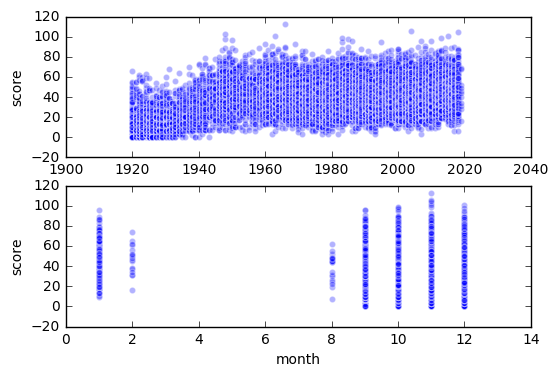

In [4]:
games['score'] = games['score1'] + games['score2']
plt.subplot(2,1,1)
sns.scatterplot(x="year", y="score", data=games, alpha=0.3)
plt.legend(prop={'family' : 'Times New Roman', 'size': 8})
plt.subplot(2,1,2)
sns.scatterplot(x="month", y="score", data=games, alpha=0.3)
plt.legend(prop={'family' : 'Times New Roman', 'size': 8})
plt.show()

Found that there are some missing data in some months and compare with other months the data in Feb and Aug are few, 'month' will not be used.

## Regression

In [5]:
# Generate average score per game for each team 
avgscore = []
for i in np.unique(games[['team1', 'team2']].values):
    s1 = games.loc[games['team1'] == i].score1
    s2 = games.loc[games['team2'] == i].score2
    avgscore.append((s1.sum() + s2.sum()) / (s1.shape[0] + s2.shape[0]))
df_avgscore = pd.DataFrame({'team': np.unique(games[['team1', 'team2']].values), 'avgscore': avgscore})

In [6]:
print(df_avgscore.dtypes)
df_avgscore.head()

avgscore    float64
team         object
dtype: object


,avgscore,team
0,0.000000,ABU
1,9.640625,AKR
2,17.798817,ARI
3,20.088095,ATL
4,6.666667,ATN


In [7]:
games = games.merge(df_avgscore, how='inner', left_on='team1', right_on='team')
games.rename(columns={'avgscore':'avgscore1'}, inplace=True)
games = games.drop('team', axis=1)
games = games.merge(df_avgscore, how='inner', left_on='team2', right_on='team')
games.rename(columns={'avgscore':'avgscore2'}, inplace=True)
games = games.drop('team', axis=1)
games.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,year,month,day,score,avgscore1,avgscore2
0,19200926,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0,1920,9,26,48,13.288462,0.000000
1,19201003,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0,1920,10,3,45,13.288462,0.000000
2,19211009,1921,0,0,ECG,MUN,1336.032,1469.651,0.402514,14,0,1.0,1921,10,9,14,11.875000,0.000000
3,19201010,1920,0,0,RII,HAM,1542.135,1444.259,0.718613,26,0,1.0,1920,10,10,26,13.288462,2.974359
4,19241012,1924,0,0,RII,HAM,1521.846,1413.563,0.730566,26,0,1.0,1924,10,12,26,13.288462,2.974359


In [8]:
#One-hot encode
games = pd.get_dummies(games, columns=['team1', 'team2'], sparse=True)
games.head()

,date,season,neutral,playoff,elo1,elo2,elo_prob1,score1,score2,result1,...,team2_THO,team2_TLM,team2_TOL,team2_TON,team2_TOR,team2_UTI,team2_WBU,team2_WHE,team2_WJA,team2_WSH
0,19200926.0,1920.0,0.0,0.0,1503.947,1300.000,0.824651,48.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19201003.0,1920.0,0.0,0.0,1516.108,1478.004,0.644171,45.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19211009.0,1921.0,0.0,0.0,1336.032,1469.651,0.402514,14.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19201010.0,1920.0,0.0,0.0,1542.135,1444.259,0.718613,26.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19241012.0,1924.0,0.0,0.0,1521.846,1413.563,0.730566,26.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Select features for models
features = [feature for feature in games.columns.tolist() if (feature!= "month" and feature != "date" and feature != "score1" and feature != "score2")]
target = ["score1", "score2"]
data_X = games[features]
data_y = games[target]

#Split the data to training set and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=61)

In [14]:
#Tree-based DecisionTree
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(random_state=61)
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
print("DecisionTree")
print("socre:",reg.score(X_test, y_test))

DecisionTree
socre: 0.65395777737


In [15]:
#Tree-based RandomForest
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=50, random_state=61, n_jobs=-1)
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
print("RandomForest")
print("socre:",reg.score(X_test, y_test))

RandomForest
socre: 0.821330937219


In [16]:
#Neural Network
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(random_state=61)
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
print("Neural Network")
print("socre:",reg.score(X_test, y_test))

Neural Network
socre: 0.816679602388


## Conclusion

+ After doing one-hot encode, dataframe can be easier to use for computing because there is no need to do a statistic computation for each team.
+ Tree-based model has a good performance especially RandomForest
+ Neural Network has a well score but running time and memory it used are more than Tree-base methods